# Import Required Libraries

In [1]:
# Set display width, load packages, import symbols
ENV["COLUMNS"]=72
using Interpolations
using Knet: Knet, dir, accuracy, progress, sgd, load143, save, gc, Param, KnetArray, Data, minibatch, nll, relu, training, dropout,sigm # param, param0, xavier_uniform
using Knet
using Images
using Plots
using LinearAlgebra
using IterTools: ncycle, takenth
using MLDatasets
using Base.Iterators: flatten
import CUDA # functional
using ImageTransformations, TestImages
# using Interpolations
array_type=(CUDA.functional() ? KnetArray{Float32} : Array{Float32})

KnetArray{Float32, N} where N

# Image Tensor Resizing Function

In [2]:
function resize_gray_image_tensor(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

function resize_MNIST(im_tensor, ratio = 1, method = BSpline(Interpolations.Linear()))
    im_tensor_copy = copy(im_tensor)
    im_new_size = Int.((size(im_tensor))[1:2] .* ratio)
    im_tensor = zeros(im_new_size[1],im_new_size[2], size(im_tensor, 3))
    
    for i in (1:size(im_tensor,3))
        img = im_tensor_copy[:,:,i]
        img_resized = Array{Float32}(imresize(Matrix{Gray{Float32}}(img'), ratio = ratio, method = method ))
        im_tensor[:,:,i] = img_resized
    end
    im_tensor_copy = nothing
    return im_tensor
end

resize_MNIST (generic function with 3 methods)

# Read Fashion-MNIST Dataset

In [3]:
xtrn,_ = FashionMNIST.traindata()
xtst,_ = FashionMNIST.testdata()
xtrn = Array{Float64, 3}(xtrn)
xtst = Array{Float64, 3}(xtst)

xtrn = resize_MNIST(xtrn, 32/28)
xtst = resize_MNIST(xtst, 32/28)

dtrn = minibatch(xtrn, 100; xsize = (32*32,:), xtype = array_type)
dtst = minibatch(xtst, 100; xsize = (32*32,:), xtype = array_type);

# Visualize Some Images

,,,,,,,,,

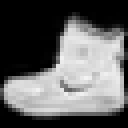
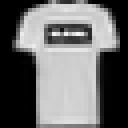
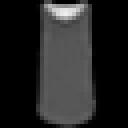
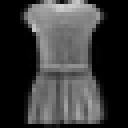
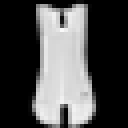
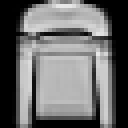
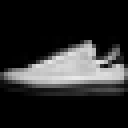
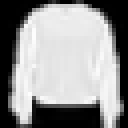
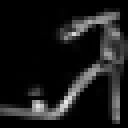
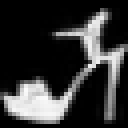

In [4]:
k = 1:10
[Matrix{Gray{Float32}}(reshape(xtrn[:,:,j], (32, 32))) for j in k]

# Print Out Some Datatypes

In [5]:
typeof(xtrn)

Array{Float64, 3}

In [6]:
typeof(dtrn)

Data{KnetArray{Float32, N} where N}

# Some Utilities and Linear AutoEncoder Model Definition

In [7]:
# Some utilities to make model definitions easier:
param(d...; init=xavier_uniform, atype=array_type)=Param(atype(init(d...)))
param0(d...; atype=array_type)=param(d...; init=zeros, atype=atype)
xavier_uniform(o,i) = (s = sqrt(2/(i+o)); 2s .* rand(o,i) .- s)

xavier_uniform (generic function with 1 method)

In [8]:
# Let's define a chain of layers
struct Chain
    layers
    Chain(layers...) = new(layers)
end
(c::Chain)(x) = (for l in c.layers; x = l(x); end; x)

# Fully-Connected Layer Definition
struct FC; w; b; f; end
FC(i::Int,o::Int,f=relu) = FC(param(o,i),param0(o),f)
(l::FC)(x) = l.f.(l.w * x .+ l.b)

# Simple Encoder and Decoder Definitions
latent_dim = 32
Encoder = Chain(FC(32*32, 128), FC(128, 64), FC(64,latent_dim))
Decoder = Chain(FC(latent_dim, 64), FC(64, 128), FC(128, 32*32, sigm))

# Model Definition
struct Model; E::Chain; D::Chain; end
Model(Encoder, Decoder) = Model(Encoder, Decoder)
(M:: Model)(x) = M.D(M.E(x))

# Batch Loss and General Loss Definition (Reconstruction Error := Mean Squared Error)

loss(m::Model,x) = sum((x - m(x)).^2) / size(x,1)

function loss(m::Model, d::Data)
    total_loss = 0
    n_instance = 0
   for x in d
        total_loss += loss(m, x) * size(x,1)
        n_instance += size(x,1)
    end
    
    total_loss /= n_instance
end

loss (generic function with 2 methods)

# Try Model on the First Batch

In [9]:
m = Model(Encoder, Decoder)

Model(Chain((FC(P(Knet.KnetArrays.KnetMatrix{Float32}(128,1024)), P(Knet.KnetArrays.KnetVector{Float32}(128)), Knet.Ops20.relu), FC(P(Knet.KnetArrays.KnetMatrix{Float32}(64,128)), P(Knet.KnetArrays.KnetVector{Float32}(64)), Knet.Ops20.relu), FC(P(Knet.KnetArrays.KnetMatrix{Float32}(32,64)), P(Knet.KnetArrays.KnetVector{Float32}(32)), Knet.Ops20.relu))), Chain((FC(P(Knet.KnetArrays.KnetMatrix{Float32}(64,32)), P(Knet.KnetArrays.KnetVector{Float32}(64)), Knet.Ops20.relu), FC(P(Knet.KnetArrays.KnetMatrix{Float32}(128,64)), P(Knet.KnetArrays.KnetVector{Float32}(128)), Knet.Ops20.relu), FC(P(Knet.KnetArrays.KnetMatrix{Float32}(1024,128)), P(Knet.KnetArrays.KnetVector{Float32}(1024)), Knet.Ops20.sigm))))

In [10]:
x = first(dtrn);
size(x)

(1024, 100)

In [11]:
size(m(x))

(1024, 100)

In [12]:
size(m.E(x)) # --> latent_dim x batch_size

(32, 100)

In [13]:
loss(m, x) # --> Batch Loss

16.273338f0

In [14]:
loss(m, dtrn) # Overall Loss on Training Set

16.055376f0

# Model Training Function

In [15]:
function train_model(m, L, dtrn, n_epochs, lr, verbose = true, watch_tst_loss = false, dtst = nothing)
    batch_loss_list = Float64[]
    loss_list = Float64[]
    tst_loss_list = Float64[]
    
    if verbose
        for epoch in (1:n_epochs)
            for x in progress(dtrn )
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                for p in params(m)
                     dp = grad(derivative, p)
                     update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.0, beta2 = 0.999))
                end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]

            
            if watch_tst_loss
                if dtst == nothing
                    print("Epoch: $epoch, Train Loss: $last_loss")
                else
                    last_tst_loss = L(m, dtst)
                    push!(tst_loss_list, last_tst_loss)
                    print("Epoch: $epoch, Train Loss: $last_loss, Test Loss: $last_tst_loss")
                end
            end
            
        end
        
    else
        for epoch in progress(1:n_epochs)
            for x in dtrn 
                x_rec = m(x)
                push!(batch_loss_list, L(m,x))
                derivative = @diff L(m,x)
                    for p in params(m)
                         dp = grad(derivative, p)
                         update!(value(p), dp, Knet.Adam(lr = lr,beta1 = 0.0, beta2 = 0.999))
                    end
            end
            push!(loss_list, L(m, dtrn))

            last_loss = loss_list[end]
            if watch_tst_loss
                if dtst == nothing
                    continue
                else
                    push!(tst_loss_list, L(m, dtst))
                end
            end
        end

    end
    return batch_loss_list, loss_list, tst_loss_list
end

train_model (generic function with 4 methods)

In [16]:
b_list, l_list, tst_l_list = train_model(m, loss, dtrn, 10, 1e-3, true, true, dtst);

┣████████████████████┫ [100.00%, 600/600, 00:14/00:14, 43.61i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 1717.33i/s] 

Epoch: 1, Train Loss: 3.5259525775909424, Test Loss: 3.5087676

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 178.42i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2061.86i/s] 

Epoch: 2, Train Loss: 2.9714860916137695, Test Loss: 2.9572446

┣████████████████████┫ [100.00%, 600/600, 00:04/00:04, 170.05i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 1525.09i/s] 

Epoch: 3, Train Loss: 2.5150206089019775, Test Loss: 2.5119228

┣████████████████████┫ [100.00%, 600/600, 00:04/00:04, 167.34i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2051.28i/s] 

Epoch: 4, Train Loss: 2.269483804702759, Test Loss: 2.2745037

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 184.44i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 1572.33i/s] 

Epoch: 5, Train Loss: 2.085073947906494, Test Loss: 2.0874085

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 193.91i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 1786.99i/s] 

Epoch: 6, Train Loss: 1.9821785688400269, Test Loss: 1.9882557

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 195.12i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 5058.17i/s] 

Epoch: 7, Train Loss: 1.8724546432495117, Test Loss: 1.8790495

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 196.47i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 2050.44i/s] 

Epoch: 8, Train Loss: 1.8536643981933594, Test Loss: 1.8573167

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 191.24i/s] 
┣                    ┫ [0.17%, 1/600, 00:00/00:00, 1808.32i/s] 

Epoch: 9, Train Loss: 1.756739854812622, Test Loss: 1.7590265

┣████████████████████┫ [100.00%, 600/600, 00:03/00:03, 191.30i/s] 


Epoch: 10, Train Loss: 1.694985270500183, Test Loss: 1.698582

In [17]:
# b_list, l_list = train_model(m, loss, dtrn, 15, 1e-3, false);

# Visualize Some Reconstructed Images on Train Set and Test Set

In [18]:
function plot_reconstructed_images(im_ori, im_rec, n_instances = 10, plot_size = (900,300))
    k = rand(1:100, n_instances)
    ori_plot_list = reshape(im_ori[:,k[1]], (32, 32))
    recon_plot_list = reshape(im_rec[:,k[1]], (32, 32))
    for j in k[2:end]
        ori_plot_list = hcat(ori_plot_list, reshape(x[:,j], (32, 32)))
        recon_plot_list = hcat(recon_plot_list, reshape(x_rec[:,j], (32, 32)))
    end
    p1 = plot(Matrix{Gray{Float32}}(ori_plot_list), title = "Original Images", size = (20,200),font =  "Courier", xtick = false, ytick = false)
    p2 = plot(Matrix{Gray{Float32}}(recon_plot_list), title = "Reconstructed Images", font = "Courier", xtick = false, ytick = false)
    plot(p1, p2, layout = (2,1), size = (900,300))
end

plot_reconstructed_images (generic function with 3 methods)

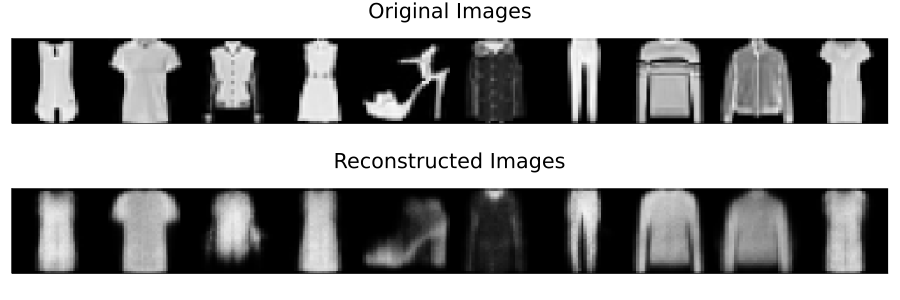

In [19]:
x = first(dtrn);

x_rec = m(x)

plot_reconstructed_images(x, x_rec)

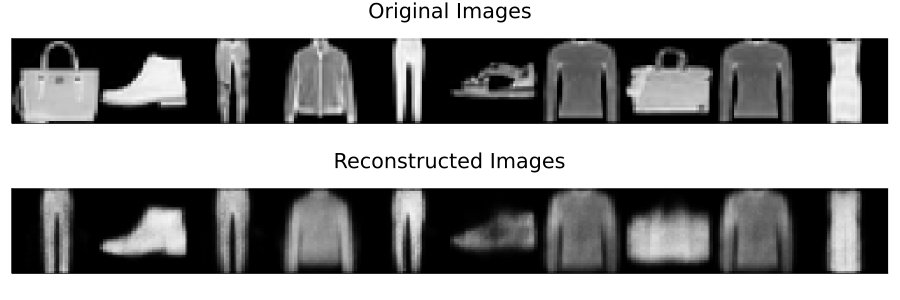

In [20]:
x_tst = first(dtst);

x_rec_tst = m(x)

plot_reconstructed_images(x_tst, x_rec_tst)

# Plot Loss Convergence

In [21]:
# epochs = 1:size(l_list,1)
# plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
#     title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
#     ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
#     yguidefontsize=18, titlefontsize = 20, size = (700, 500))

# plot!(epochs,tst_l_list ,label = "Test Loss", xlabel = "Epochs", ylabel = "Loss",
#     title = "Test Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
#     ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
#     yguidefontsize=18, titlefontsize = 20, size = (700, 500))

In [22]:
function plot_loss_convergence(trn_loss, tst_loss = nothing, figsize = (700, 500), epochs = nothing)
    if epochs == nothing
         epochs = 1:size(trn_loss,1)
    end    
    if tst_loss != nothing
        if size(trn_loss,1) != size(tst_loss,1)
            print("The loss vectors for train and test do not have the same size")
            return 0
        else
            plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
            title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
            ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
            yguidefontsize=18, titlefontsize = 20, size = figsize)
            plot!(epochs,tst_l_list ,label = "Test Loss", title = "Train & Test Loss w.r.t. Epochs")
        end
    else
        plot(epochs,l_list ,label = "Train Loss", xlabel = "Epochs", ylabel = "Loss",
        title = "Train Loss w.r.t. Epochs", minorgrid = true, xtickfontsize = 18,
        ytickfontsize = 18, legendfontsize = 18, xguidefontsize=18, 
        yguidefontsize=18, titlefontsize = 20, size = figsize)
    end
    
end

plot_loss_convergence (generic function with 4 methods)

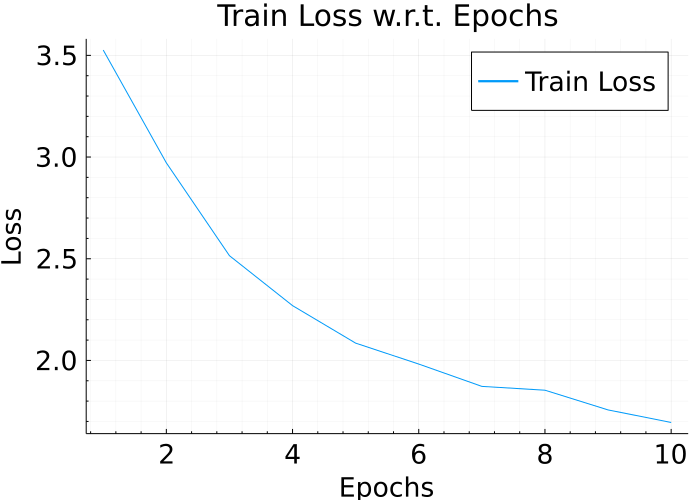

In [23]:
plot_loss_convergence(l_list)

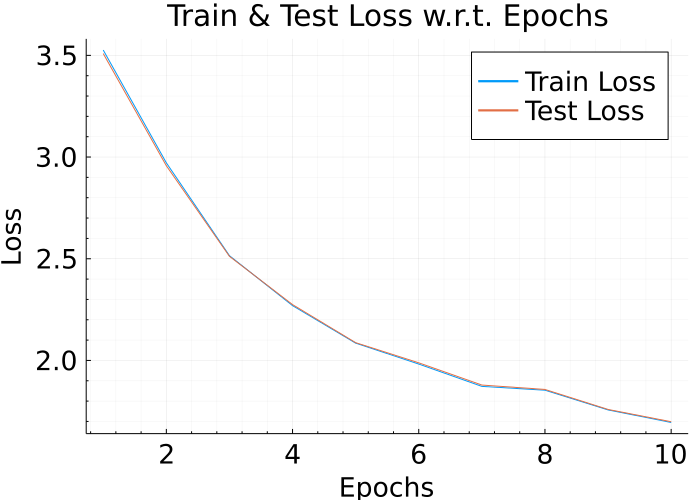

In [24]:
plot_loss_convergence(l_list, tst_l_list)